In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers

In [5]:
#from google.colab import drive
#drive.mount('/content/drive')

In [6]:
from zipfile import ZipFile
with ZipFile('/content/drive/MyDrive/archive (2).zip', 'r') as zipobj:
  zipobj.extractall('/content/PlantVillage')


In [7]:
PlantVillage = "/content/PlantVillage/PlantVillage"

In [8]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/PlantVillage/PlantVillage",
    shuffle=True,
    image_size = (256, 256),
    batch_size = 32

)

Found 2152 files belonging to 3 classes.


In [9]:
import os
for dirpath, dirnames, filenames in os.walk("PlantVillage"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 1 directories and 0 images in 'PlantVillage'.
There are 3 directories and 0 images in 'PlantVillage/PlantVillage'.
There are 0 directories and 152 images in 'PlantVillage/PlantVillage/Potato___healthy'.
There are 0 directories and 1000 images in 'PlantVillage/PlantVillage/Potato___Late_blight'.
There are 0 directories and 1000 images in 'PlantVillage/PlantVillage/Potato___Early_blight'.


In [10]:
len(dataset)

68

In [11]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [12]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [13]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())


(32, 256, 256, 3)
[1 1 0 0 1 1 0 1 0 0 0 1 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 1]


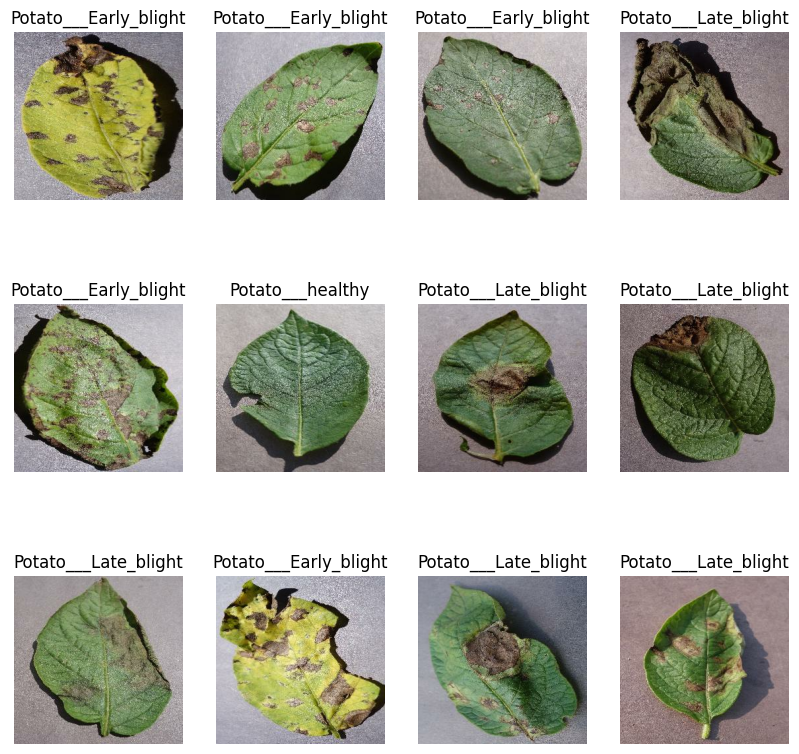

In [14]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")


In [15]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [16]:
train_ds = dataset.take(54)
len(train_ds)

54

In [17]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [18]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [19]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [20]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [21]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds


In [22]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [23]:
len(train_ds)

54

In [24]:
len(val_ds)

6

In [25]:
len(test_ds)

8

In [26]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [28]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [29]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [30]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [31]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [32]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    epochs=50,
)

Epoch 1/50
54/54 [==============================] - 27s 104ms/step - loss: 0.8558 - accuracy: 0.5330 - val_loss: 0.6714 - val_accuracy: 0.6875
Epoch 2/50
54/54 [==============================] - 3s 60ms/step - loss: 0.6486 - accuracy: 0.7182 - val_loss: 0.5287 - val_accuracy: 0.7708
Epoch 3/50
54/54 [==============================] - 3s 61ms/step - loss: 0.4974 - accuracy: 0.7917 - val_loss: 0.4818 - val_accuracy: 0.8125
Epoch 4/50
54/54 [==============================] - 3s 60ms/step - loss: 0.3868 - accuracy: 0.8380 - val_loss: 0.6540 - val_accuracy: 0.6927
Epoch 5/50
54/54 [==============================] - 3s 59ms/step - loss: 0.3023 - accuracy: 0.8877 - val_loss: 0.4431 - val_accuracy: 0.7969
Epoch 6/50
54/54 [==============================] - 3s 61ms/step - loss: 0.1935 - accuracy: 0.9340 - val_loss: 0.2381 - val_accuracy: 0.9167
Epoch 7/50
54/54 [==============================] - 3s 62ms/step - loss: 0.2264 - accuracy: 0.9172 - val_loss: 0.2088 - val_accuracy: 0.9115
Epoch 8/50


In [33]:
scores = model.evaluate(test_ds)
scores

8/8 [==============================] - 3s 27ms/step - loss: 0.0390 - accuracy: 0.9883


[0.03898266702890396, 0.98828125]

In [34]:
from tensorflow.keras.models import load_model
model_version="4"
model.save(f"../saved_models/{model_version}")